In [1]:
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import DataFrame
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
rn.seed(42)
import copy
from dateutil.relativedelta import relativedelta

In [2]:
# 设置图片大小
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [4]:
def log_money(df, column):
    df['log_money'] = np.log(df[column])
    return df

In [5]:
# 对异常值使用前后n个星期的同一天数据的平均值填补
def weekinterpolation(ts,n):
    tsna=ts[ts.isnull().values==True]
    for tsnai in np.arange(len(tsna)):
        tempn=0
        sumna=0       
        for tsnaj in np.arange(n): 
            nday=(tsnaj+1)*7
            new_index_down = tsna.index[tsnai] - relativedelta(days=nday)
            new_index_up = tsna.index[tsnai] + relativedelta(days=nday)       
            if new_index_down < ts.index[0] and new_index_up > ts.index[-1]:
                continue
            elif new_index_down < ts.index[0] and new_index_up <= ts.index[-1]:
                if np.isnan(ts[new_index_up]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_up]
            elif new_index_down >= ts.index[0] and new_index_up > ts.index[-1]:
                if np.isnan(ts[new_index_down]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_down]
            else:
                if np.isnan(ts[new_index_up]) and np.isnan(ts[new_index_down]):
                    continue
                elif np.isnan(ts[new_index_up]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_down]
                elif np.isnan(ts[new_index_down]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_up]
                else:
                    tempn =tempn + 2
                    sumna=sumna+ts[new_index_down] + ts[new_index_up]             
        if tempn==0:
            continue
        ts[tsna.index[tsnai]]=sumna/tempn    
    return ts

In [6]:
####当序列中的值大于百分之upn或小于百分之downn时认为是异常值，采用n周期值替换
def Custompercentilenan(ts,downn,upn,n):
    downpercentile=np.percentile(ts,downn)
    uppercentile=np.percentile(ts,upn)
    tstmp=copy.deepcopy(ts)
    for i in np.arange(len(ts)):
        if ts[i] > uppercentile:
            tstmp[i]=np.nan
        elif ts[i] < downpercentile:
            tstmp[i]=np.nan
        else:
            tstmp[i]=copy.deepcopy(ts[i]) 
            
    ######周期性差值
    tstmp1=weekinterpolation(tstmp,n)
    
    return tstmp1

In [58]:
# 读取数据的同时把data转换为datetime格式并设为Index
df = pd.read_csv('data/7529zizhufk.csv', parse_dates = True, 
                 index_col=0)

df.head()

money
data                
2014-01-01   14700.0
2014-01-02  455550.0
2014-01-03   80000.0
2014-01-04    6500.0
2014-01-05   51600.0

In [59]:
# 检查时间戳是否唯一
df.index.is_unique

False

In [60]:
# 对同一天的数据累加
grouped = df.groupby(level=0).sum()
grouped.head()

money
data                
2014-01-01  128900.0
2014-01-02  924700.0
2014-01-03  378000.0
2014-01-04  162700.0
2014-01-05  207800.0

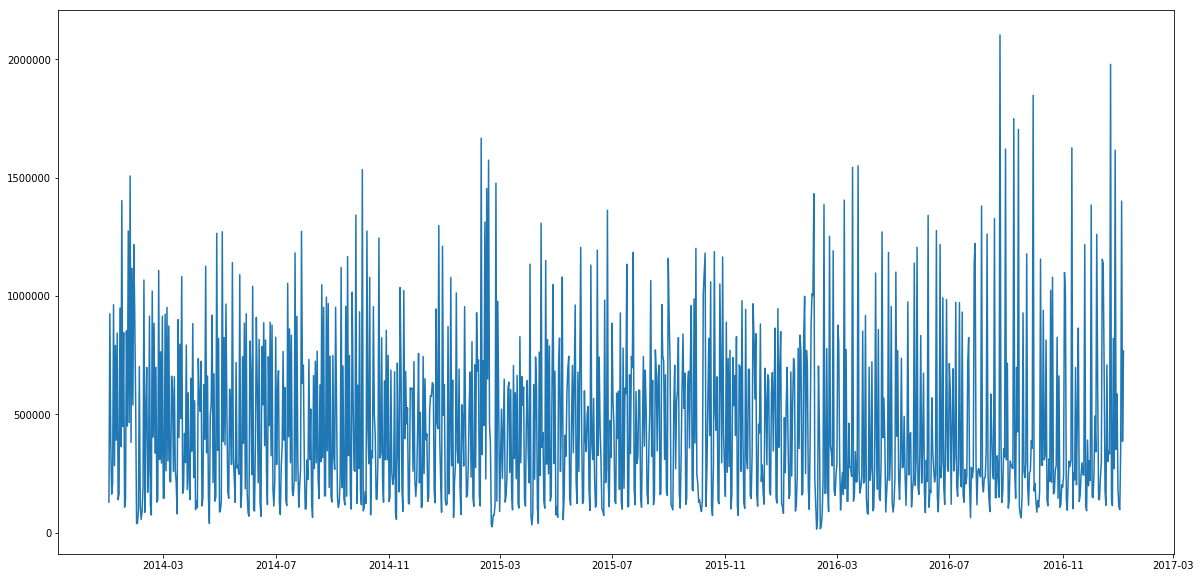

In [61]:
plt.plot(grouped.index, grouped.money)
plt.show()

In [62]:
testStationarity(grouped.money)

Test Statistic                -7.314929e+00
p-value                        1.236412e-10
#Lags Used                     2.200000e+01
Number of Observations Used    1.079000e+03
Critical Value (5%)           -2.864222e+00
Critical Value (1%)           -3.436425e+00
Critical Value (10%)          -2.568198e+00
dtype: float64

In [63]:
# 对同一天数据累加后，取log后导出，之后与预测值作对比使用
original_log = log_money(grouped, 'money')

original_log = original_log.drop(['money'],axis=1)
original_log.head()

original_log.to_csv('data/original_log_7529.csv')

log_money
data                 
2014-01-01  11.766792
2014-01-02  13.737225
2014-01-03  12.842649
2014-01-04  11.999663
2014-01-05  12.244331

In [64]:
testStationarity(grouped.log_money)

Test Statistic                -7.288157e+00
p-value                        1.440519e-10
#Lags Used                     2.000000e+01
Number of Observations Used    1.081000e+03
Critical Value (5%)           -2.864217e+00
Critical Value (1%)           -3.436414e+00
Critical Value (10%)          -2.568196e+00
dtype: float64

In [11]:
# 把前后10%定义为异常值，把异常值用对应前后一个星期的那一天的平均值替换
ts = Custompercentilenan(grouped.money,10,90,1)

In [12]:
grouped = pd.DataFrame({'money':ts.values},index=ts.index)

In [13]:
# # 方法二：根据平均值和标准差
# grouped.money.std(), grouped.money.mean()

# # 检测异常值
# max_money = grouped.money.mean() + 3*df.money.std()
# # 超出三倍标准差的为异常值
# outliers = grouped[np.abs(grouped.money-grouped.money.mean())>=(3*df.money.std())] 
# outliers[:10]

# # 对于异常值，使用可接受的最大值代替
# grouped['money'] = grouped['money'].map(lambda x: max_money if x > max_money else x)

In [ ]:
# 方法二：根据百分比
# drop_indices = []
# percent_25 = np.percentile(grouped['money'],25)
# percent_75 = np.percentile(grouped['money'],75)
# normal_range = (percent_75 - percent_25) * 1
# outlier_indexs = grouped[(grouped['money'] < percent_25 - normal_range) | (grouped['money'] > percent_75 + normal_range)].index
# drop_indices.extend(list(outlier_indexs ))

In [65]:
# # 发现异常值
# drop_indices
# # 删除异常值
# grouped = grouped.drop(drop_indices)

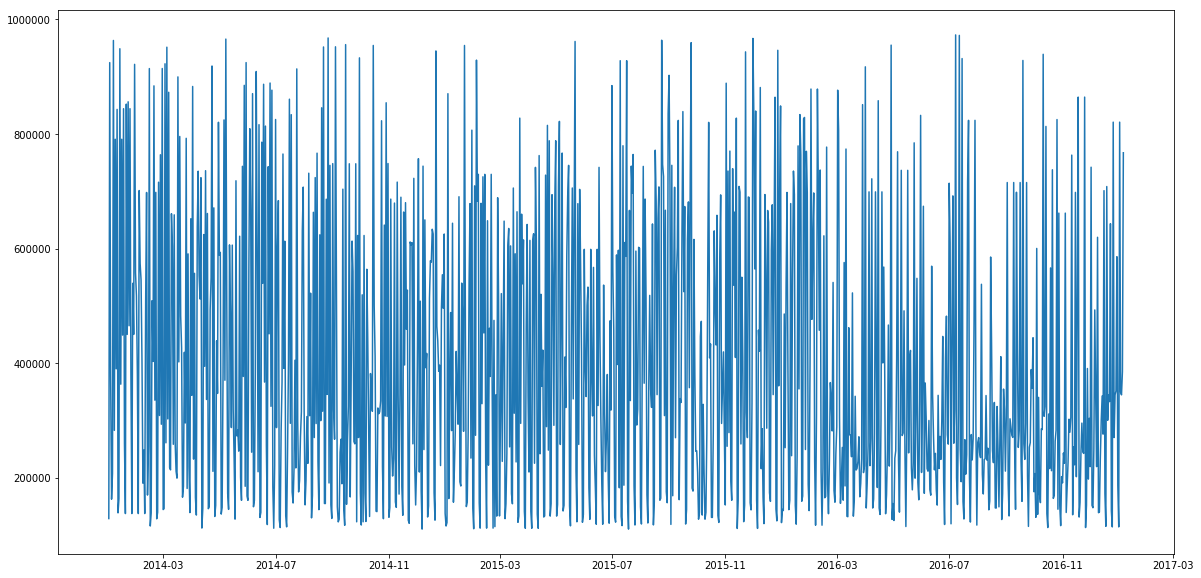

In [14]:
plt.plot(grouped.index, grouped.money)
plt.show()

In [15]:
grouped = log_money(grouped, 'money')

grouped.head()

money  log_money
data                           
2014-01-01  128900.0  11.766792
2014-01-02  924700.0  13.737225
2014-01-03  378000.0  12.842649
2014-01-04  162700.0  11.999663
2014-01-05  207800.0  12.244331

In [16]:
# 计算每天的交易数
# import seaborn as sns 
daily = df.groupby(pd.TimeGrouper(freq='D'))['money'].count()
# ax = daily.plot(kind='bar')
# plt.show()

In [17]:
grouped = grouped.drop(['money'],axis = 1)
grouped.head()

log_money
data                 
2014-01-01  11.766792
2014-01-02  13.737225
2014-01-03  12.842649
2014-01-04  11.999663
2014-01-05  12.244331

In [18]:
len(daily)

1102

In [19]:
# 删除交易数为0的记录
daily_with_name = pd.DataFrame({'data':daily.index, 'count':daily.values})

daily_with_name[['count']] = daily_with_name['count'].astype(int)

unique_daily = daily_with_name[daily_with_name['count'] > 0]

unique_daily.head()

count       data
0      3 2014-01-01
1      3 2014-01-02
2      3 2014-01-03
3      3 2014-01-04
4      3 2014-01-05

In [20]:
unique_daily.shape

(1102, 2)

In [21]:
grouped.reset_index(inplace=True)

grouped.head()

data  log_money
0 2014-01-01  11.766792
1 2014-01-02  13.737225
2 2014-01-03  12.842649
3 2014-01-04  11.999663
4 2014-01-05  12.244331

In [22]:
# 合并两个dataframe
grouped = pd.merge(grouped, unique_daily, on="data")

grouped.head()

data  log_money  count
0 2014-01-01  11.766792      3
1 2014-01-02  13.737225      3
2 2014-01-03  12.842649      3
3 2014-01-04  11.999663      3
4 2014-01-05  12.244331      3

In [23]:
# 把data转换为fatetime格式
grouped.set_index("data", inplace=True)
grouped.index = pd.DatetimeIndex(grouped.index)

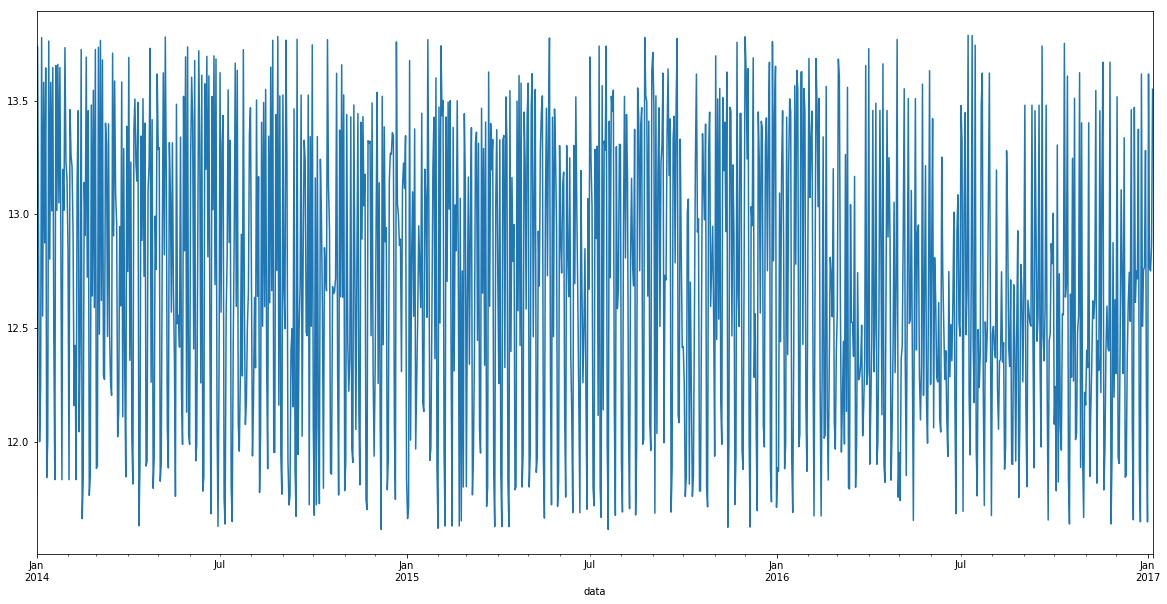

In [24]:
# 画图，观测时间序列是否平稳
grouped['log_money'][:].plot()
plt.show()

In [25]:
res = testStationarity(grouped.log_money)
res

Test Statistic                   -4.747710
p-value                           0.000068
#Lags Used                       20.000000
Number of Observations Used    1081.000000
Critical Value (5%)              -2.864217
Critical Value (1%)              -3.436414
Critical Value (10%)             -2.568196
dtype: float64

为grouped增加其他特征

In [30]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
grouped.reset_index(inplace=True)
# 星期几
grouped['week_number'] = grouped['data'].dt.dayofweek
# 是否为工作日
grouped['weekday'] = (grouped['week_number'] // 5 == 1).astype(int)
# 是否为季度的最后一天
grouped['is_quarter_end'] = grouped['data'].dt.is_quarter_end
grouped['is_quarter_end'] = grouped['is_quarter_end'].astype(int)
# 是否为节假日
dr = grouped['data']
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
grouped['holiday'] = grouped['data'].isin(holidays)
grouped['holiday'] = grouped['holiday'].map(lambda x: 1 if x == True else 0)

grouped.head()

data  log_money  count  week_number  weekday  is_quarter_end  holiday
0 2014-01-01  11.766792      3            2        0               0        1
1 2014-01-02  13.737225      3            3        0               0        0
2 2014-01-03  12.842649      3            4        0               0        0
3 2014-01-04  11.999663      3            5        1               0        0
4 2014-01-05  12.244331      3            6        1               0        0

截取一部分数据做可视化分析（为了更佳的可视化效果）

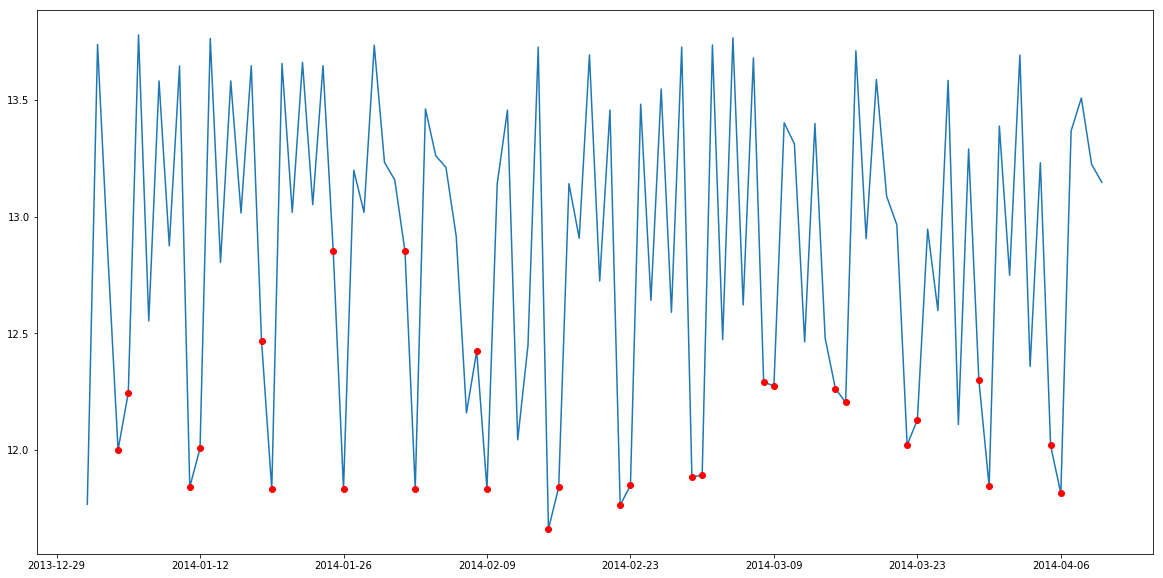

In [31]:
part_grouped = grouped[:100]
# 把index转换为datetime格式
part_grouped.set_index("data", inplace=True)
part_grouped.index = pd.DatetimeIndex(part_grouped.index)
# 观察交易量和双休是否相关
plt.plot(part_grouped.index, part_grouped.log_money)
plt.plot(part_grouped[part_grouped.weekday==1].index, part_grouped[part_grouped.weekday==1].log_money, 'ro')
plt.show()

- 双休日的交易量通常比较低  
- 通常频率为一个星期

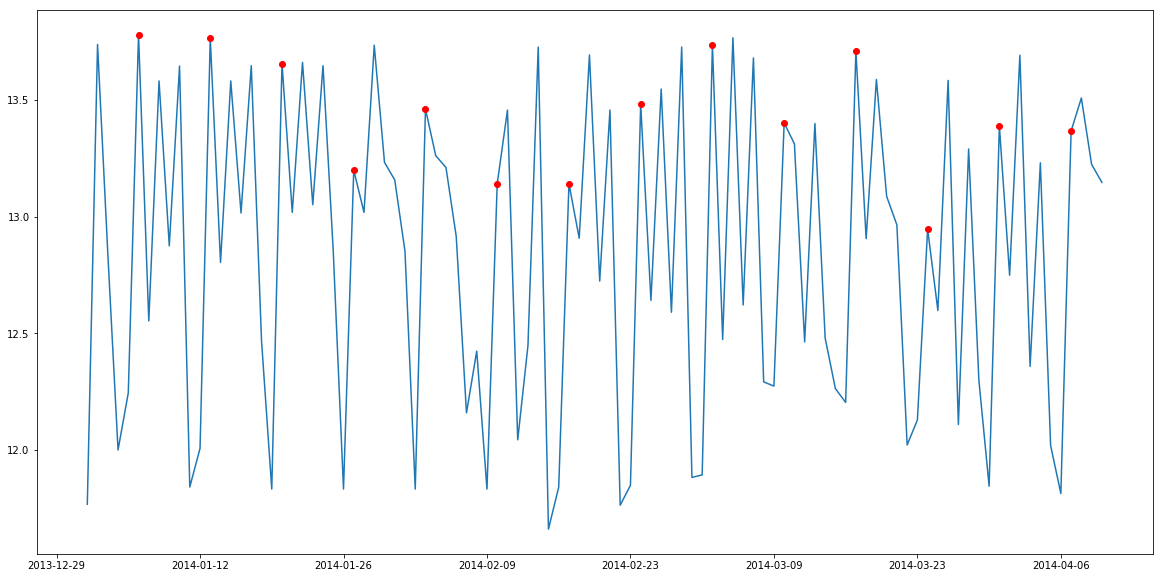

In [32]:
# 观察交易量是否在周一达到峰值
plt.plot(part_grouped.index, part_grouped.log_money)
plt.plot(part_grouped[part_grouped.week_number==0].index, part_grouped[part_grouped.week_number==0].log_money, 'ro')
plt.show()

- 通常周一的交易量比较高

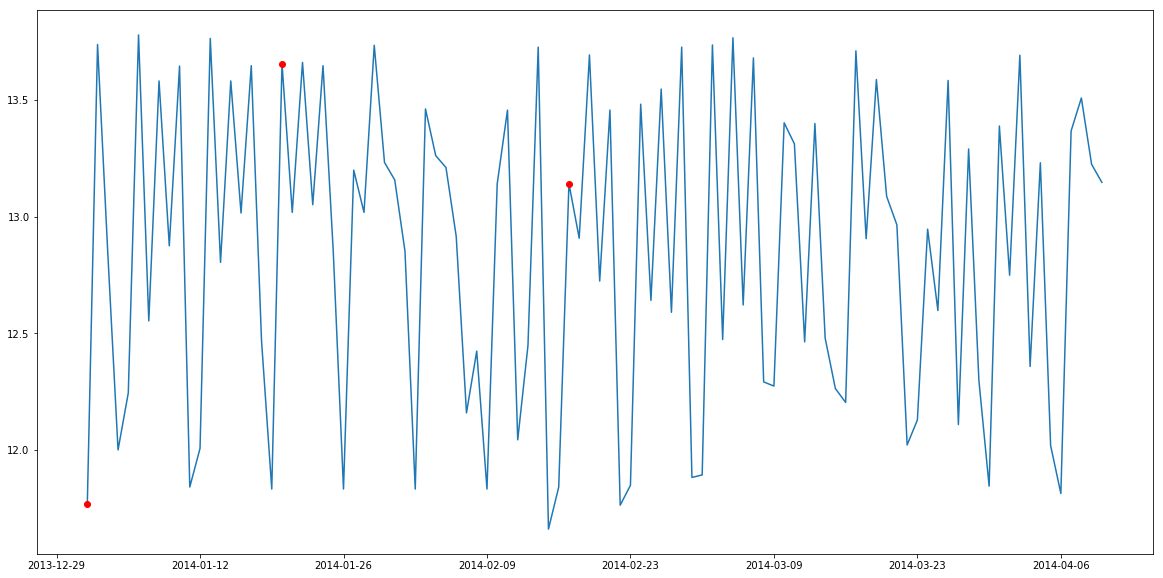

In [33]:
# 观察交易量和双休是否相关
plt.plot(part_grouped.index, part_grouped.log_money)
plt.plot(part_grouped[part_grouped.holiday==True].index, part_grouped[part_grouped.holiday==True].log_money, 'ro')
plt.show()

- 节假日的交易量没有明显特征

In [34]:
# 把data转换为datetime格式
grouped.set_index("data", inplace=True)
grouped.index = pd.DatetimeIndex(grouped.index)

In [35]:
grouped.head()

log_money  count  week_number  weekday  is_quarter_end  holiday
data                                                                       
2014-01-01  11.766792      3            2        0               0        1
2014-01-02  13.737225      3            3        0               0        0
2014-01-03  12.842649      3            4        0               0        0
2014-01-04  11.999663      3            5        1               0        0
2014-01-05  12.244331      3            6        1               0        0

In [36]:
# df_money = grouped[['money']]
# # 把格式转换为numpy array，加速计算
# values = df_money.values

In [37]:
# # 把数据范围缩小到0-100
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# values = values.astype('float32')
# scaler = MinMaxScaler(feature_range = (0,100))
# scaled = scaler.fit_transform(values)

# scaled[:10]

In [38]:
# grouped['scaled_money'] = scaled

In [39]:
# grouped.head()

In [40]:
# df_money = grouped[['scaled_money']]
# df_money.to_csv('df_money.csv')

In [41]:
from __future__ import print_function
from scipy import  stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

利用ARMA的思想，对时间序列的前10的每一天作为一个新特征，观察其对当天的结果的影响

In [45]:
# 把数据转换成可训练格式
def series_to_surprived(data, n_in=1, n_out=1, dropnan=True):
    # 列数
    n_vars = 1
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        # 转换成list, 前移一位
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [46]:
reframed = series_to_surprived(grouped['log_money'], 20, 1)

grouped = grouped[20:]

reframed = pd.concat([grouped,reframed], axis=1)

reframed = reframed.drop(['log_money'],axis=1)

reframed.head()

count  week_number  weekday  is_quarter_end  holiday  var1(t-20)  \
data                                                                           
2014-01-21      3            1        0               0        0   11.766792   
2014-01-22      3            2        0               0        0   13.737225   
2014-01-23      3            3        0               0        0   12.842649   
2014-01-24      3            4        0               0        0   11.999663   
2014-01-25      3            5        1               0        0   12.244331   

            var1(t-19)  var1(t-18)  var1(t-17)  var1(t-16)    ...      \
data                                                          ...       
2014-01-21   13.737225   12.842649   11.999663   12.244331    ...       
2014-01-22   12.842649   11.999663   12.244331   13.778172    ...       
2014-01-23   11.999663   12.244331   13.778172   12.552495    ...       
2014-01-24   12.244331   13.778172   12.552495   13.580927    ...       
2014-01-25   13.778172   12.552495   13.580927   12.874415    ...       

            var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  \
data                                                                           
2014-01-21  12.006401  13.763059  12.803259  13.580927  13.015001  13.646204   
2014-01-22  13.763059  12.803259  13.580927  13.015001  13.646204  12.468245   
2014-01-23  12.803259  13.580927  13.015001  13.646204  12.468245  11.832106   
2014-01-24  13.580927  13.015001  13.646204  12.468245  11.832106  13.655635   
2014-01-25  13.015001  13.646204  12.468245  11.832106  13.655635  13.017669   

            var1(t-3)  var1(t-2)  var1(t-1)    var1(t)  
data                                                    
2014-01-21  12.468245  11.832106  13.655635  13.017669  
2014-01-22  11.832106  13.655635  13.017669  13.660347  
2014-01-23  13.655635  13.017669  13.660347  13.050653  
2014-01-24  13.017669  13.660347  13.050653  13.646204  
2014-01-25  13.660347  13.050653  13.646204  12.850817  

[5 rows x 26 columns]

In [47]:
# 把data转换为datetime格式
# reframed.set_index("data", inplace=True)
# reframed.index = pd.DatetimeIndex(reframed.index)

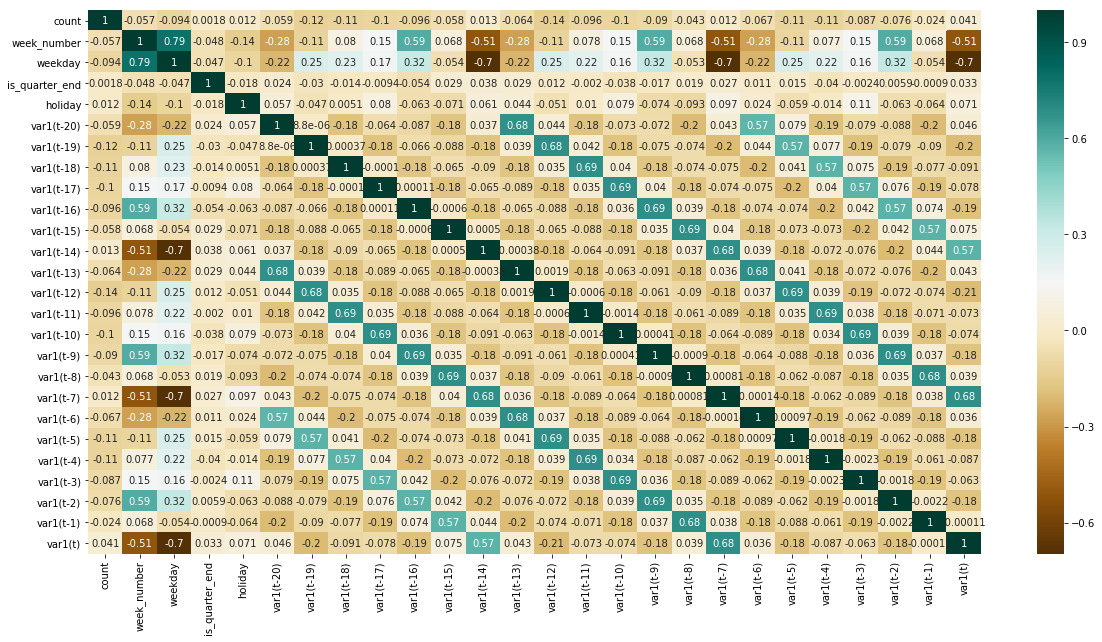

In [48]:
# 画出相关系数图
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import seaborn as sns
matrix = reframed.corr()
g= sns.heatmap(matrix,cmap = "BrBG", annot = True)
plt.show()

- var1(t)为预测值，可见、week_number, weekday, var1(t-14), var1(t-7)对当天的预测值影响较大  
- week_number和weekday有很强的联系性  
- 在后期建模过程中我们可以删掉相关性较小的特征和weekday特征  

In [49]:
# # 把reframed数据作为初步处理后的数据导出，供后期建模使用
reframed.to_csv('data/bank_after_clean_20_7529.csv')

In [50]:
reframed.head()

count  week_number  weekday  is_quarter_end  holiday  var1(t-20)  \
data                                                                           
2014-01-21      3            1        0               0        0   11.766792   
2014-01-22      3            2        0               0        0   13.737225   
2014-01-23      3            3        0               0        0   12.842649   
2014-01-24      3            4        0               0        0   11.999663   
2014-01-25      3            5        1               0        0   12.244331   

            var1(t-19)  var1(t-18)  var1(t-17)  var1(t-16)    ...      \
data                                                          ...       
2014-01-21   13.737225   12.842649   11.999663   12.244331    ...       
2014-01-22   12.842649   11.999663   12.244331   13.778172    ...       
2014-01-23   11.999663   12.244331   13.778172   12.552495    ...       
2014-01-24   12.244331   13.778172   12.552495   13.580927    ...       
2014-01-25   13.778172   12.552495   13.580927   12.874415    ...       

            var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  \
data                                                                           
2014-01-21  12.006401  13.763059  12.803259  13.580927  13.015001  13.646204   
2014-01-22  13.763059  12.803259  13.580927  13.015001  13.646204  12.468245   
2014-01-23  12.803259  13.580927  13.015001  13.646204  12.468245  11.832106   
2014-01-24  13.580927  13.015001  13.646204  12.468245  11.832106  13.655635   
2014-01-25  13.015001  13.646204  12.468245  11.832106  13.655635  13.017669   

            var1(t-3)  var1(t-2)  var1(t-1)    var1(t)  
data                                                    
2014-01-21  12.468245  11.832106  13.655635  13.017669  
2014-01-22  11.832106  13.655635  13.017669  13.660347  
2014-01-23  13.655635  13.017669  13.660347  13.050653  
2014-01-24  13.017669  13.660347  13.050653  13.646204  
2014-01-25  13.660347  13.050653  13.646204  12.850817  

[5 rows x 26 columns]

对数据集进行异常值处理后导出，基于此数据集计算准确率

In [51]:
# 读取数据的同时把data转换为datetime格式并设为Index
df = pd.read_csv('data/7529zizhufk.csv', parse_dates = True, 
                 index_col=0)

df.head()

money
data                
2014-01-01   14700.0
2014-01-02  455550.0
2014-01-03   80000.0
2014-01-04    6500.0
2014-01-05   51600.0

In [52]:
# 对同一天的数据累加
grouped = df.groupby(level=0).sum()
grouped.head()

money
data                
2014-01-01  128900.0
2014-01-02  924700.0
2014-01-03  378000.0
2014-01-04  162700.0
2014-01-05  207800.0

In [53]:
# 把前后10%定义为异常值，把异常值用对应前后一个星期的那一天的平均值替换
ts = Custompercentilenan(grouped.money,10,90,1)

In [54]:
grouped = pd.DataFrame({'money':ts.values},index=ts.index)

In [55]:
grouped.head()

money
data                
2014-01-01  128900.0
2014-01-02  924700.0
2014-01-03  378000.0
2014-01-04  162700.0
2014-01-05  207800.0

In [56]:
grouped.to_csv('data/original_log_no_abnorm_7529.csv')